## Context
KOV-4206 - Incident Impact - data scale (number of records)

- Comparison of the overall distribution from the model with real events
- Split by more granular event-types if the data allows

## Limitations

1. Scope: only covers F1000 companies
2. Availabiliy model data: only available for companies where a `financial_quantification_input.json` file is generated (currently 948/1000)
3. Data quality - validity of events data around the fields `data_records_impacted` and `compromised_data_types` is unknown
4. Missing field in events data - the events data does not have a field that captures the number of data records within an entity rather it only includes the data records impacted by an event. We therefore assume that the difference in the `data_records_impacted` between the events and model data is driven by the field `data_scale` in the model data and try and find an appropriate adjustment.
    

## Data

1. F1000 model data - table - `dna-db.postgres.model_events`
    - model version: v2022.2.3 FQ model
    - run date: 2022-04-20
2. Events data 
    - table - `dna-db.postgres.data_sources_events`
    - table - `dna-db.postgres.data_sources_entities`

## Conclusion
1. The scale of `data_records_impacted` in the events data is orders of magnitude lower than that in the model 
2. In trying to compensate for the difference between the `data_records_impacted` between the model and events data, we attempted to rescale the `data_scale` factor in the model data. However, it was difficult to establish the underlying distribution and parameters of this new scaling factor `data_scale_corrected`.
3. Similar to the field: `data_records_impacted` the distribution of `compromised_data_types` is a lot more sparse for the events as compared to the model. 

## Testing Detail

### Data Records Impacted



In [16]:
# builds the connection to azure:
#%matplotlib inline

import os
import sys
import numpy as np
import matplotlib as mpl
#import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn
from pandas_profiling import ProfileReport
from matplotlib.figure import Figure

# import custom modules:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib._get_data import *
from lib._stats import *
#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


server connected


In [2]:
pd.set_option('display.precision',3)
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',100)
pd.set_option('display.max_info_rows',100)
pd.set_option('display.max_info_columns',50)
pd.set_option('display.max_colwidth',0)
pd.options.display.float_format='{:,.2f}'.format

In [19]:
pn.extension()

In [3]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

In [4]:
#EDA - F1000 proxy events and entities 
events = read_f1k_table()
profile_events_data = ProfileReport(events, title='model_events_EDA',minimal=True)
profile_events_data.to_file('data/model_events_EDA.html')

server connected


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Get model data

In [5]:
# get model_data
df_model = pd.read_sql_query('''
    select
        model_events.run_id::text as entity,
        model_entities.number_of_data_records,
        model_events.data_scale,
        model_entities.data_split_pci,
        model_entities.data_split_other,
        model_entities.data_split_phi,
        model_entities.data_split_pii,
        model_entities.number_of_data_records * model_events.data_scale as data_records_impacted,
        model_events.event_type as event_type
    from
        model_events left outer join model_entities on model_events.run_id = model_entities.run_id
''', engine)
df_model.pop('entity')
df_model['source'] = 'model'


In [6]:
#EDA - F1000 model data
profile_model_data = ProfileReport(df_model, title='F1000_model_data_EDA',minimal=True)
profile_model_data.to_file('data/F1000_model_data.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Get Events data

In [7]:
df_events = read_f1k_table()[['compromised_data_amount','compromised_data_types','event_type']].rename(columns={'compromised_data_amount':'data_records_impacted'})
df_events.loc[:,'source']='events'


server connected


### Compare data records impacted


In [8]:
#events data quality check
print(f"{df_events['data_records_impacted'].isnull().mean()*100:.02f}% of actual events have no data records impacted populated")
print(f"{(df_events['data_records_impacted']==0).mean()*100:.02f}% of actual events have 0 data records impacted")
print(f"{(df_events['data_records_impacted']=='None').mean()*100:.02f}% of actual events have the value 'None' for data records impacted")

0.00% of actual events have no data records impacted populated
0.00% of actual events have 0 data records impacted
25.92% of actual events have the value 'None' for data records impacted


In [9]:
#model data quality check
print(f"{df_model['data_records_impacted'].isnull().mean()*100:.02f}% of model events have no data records impacted populated")
print(f"{(df_model['data_records_impacted']==0).mean()*100:.02f}% of model events have 0 data records impacted")
print(f"{(df_model['data_records_impacted']=='None').mean()*100:.02f}% of model events have the value 'None' for data records impacted")

46.46% of model events have no data records impacted populated
0.00% of model events have 0 data records impacted
0.00% of model events have the value 'None' for data records impacted


In [10]:
#Normalize the events data - the fields `data_records_impacted` and `compromised_data_types` are presented as lists in the table
df_modified_events = df_events.copy()
compromised_data_types_replacements = {'Corporate Digital Assets':'Corporate_Digital_Assets','Corporate Financial Assets':'Corporate_Financial_Assets','Business Interruption':'Business_Interruption'}
df_modified_events['data_records_impacted'] = df_modified_events.loc[:,'data_records_impacted'].str.strip('[]')
df_modified_events['compromised_data_types'] = df_modified_events.loc[:,'compromised_data_types'].str.strip('[]').replace(compromised_data_types_replacements, regex=True).str.split(' ')
df_modified_events = df_modified_events.explode('compromised_data_types')
df_modified_events = df_modified_events.explode('data_records_impacted').reset_index()
df_modified_events['data_records_impacted'] = df_modified_events['data_records_impacted'].str.strip(' ')
df_modified_events['data_records_impacted'].replace(['None','nan', 'nan  0',''],np.nan,inplace=True,regex=True)
df_modified_events['data_records_impacted']= pd.to_numeric(df_modified_events['data_records_impacted'], errors='coerce')
df_modified_events.dropna(subset='data_records_impacted',inplace=True)
df_modified_events.drop_duplicates(keep='first',subset='index',inplace=True)
df_modified_events.drop(columns='index',inplace=True)

In [11]:
#create plot data
events_data = df_modified_events[['data_records_impacted','source']]
model_data = df_model[['number_of_data_records','data_scale','data_records_impacted','source']]
plot_data = pd.concat([model_data, events_data],ignore_index=True)

In [12]:
events_data['data_records_impacted'].describe()

count   3,175.00      
mean    2,020,756.42  
std     15,548,490.11 
min     0.00          
25%     1.00          
50%     1.00          
75%     1,000.00      
max     319,000,000.00
Name: data_records_impacted, dtype: float64

In [13]:
model_data['data_records_impacted'].describe()

count   3,048,392.00    
mean    23,255,628.13   
std     55,530,174.19   
min     7,280.68        
25%     1,911,643.72    
50%     5,435,435.52    
75%     18,340,163.78   
max     1,044,210,194.63
Name: data_records_impacted, dtype: float64

### Plots before normalization

Text(0.5, 0, 'data records impacted')

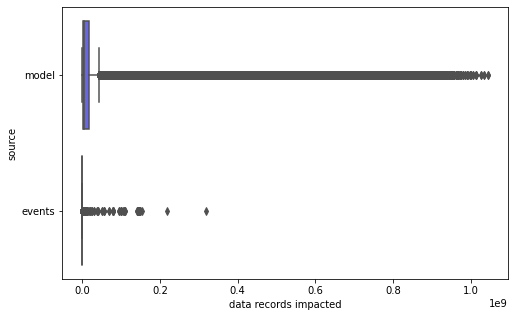

In [17]:
# plot data
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(data=plot_data, x="data_records_impacted", y="source", orient="h", ax=ax)
ax.set_xlabel("data records impacted")

Matplotlib(Figure)
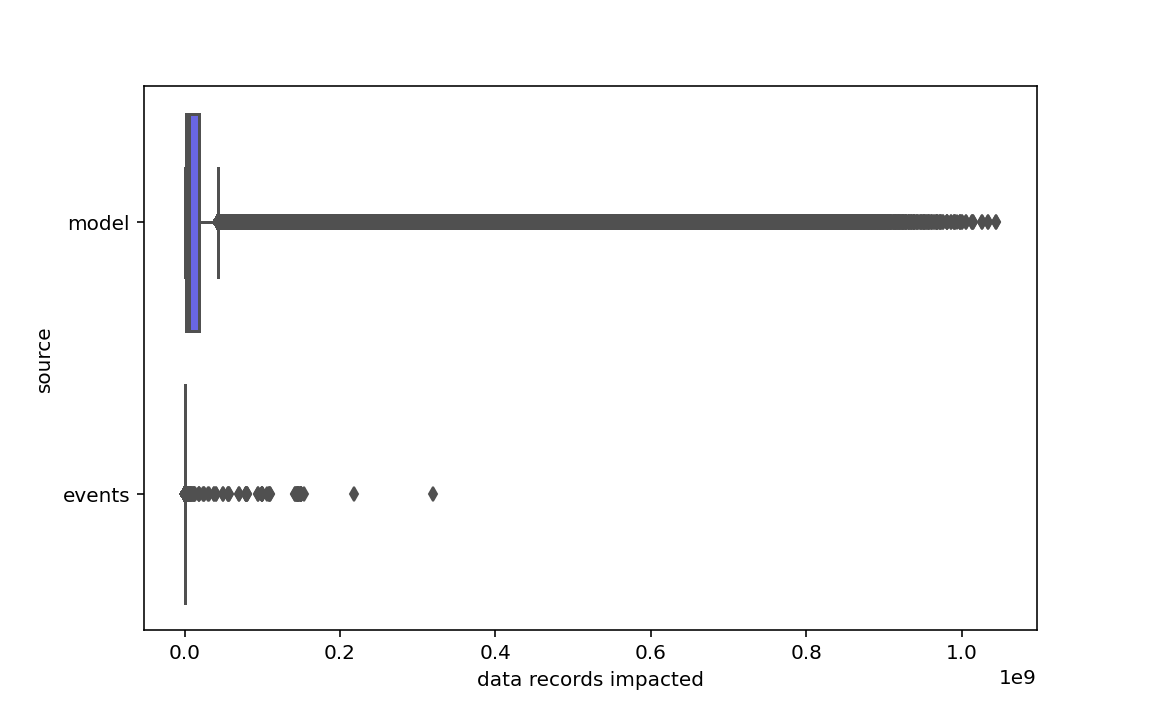

In [20]:
#panel plot 
fig = Figure(figsize=(8,5))
ax = fig.subplots(1,1)
sns.boxplot(data=plot_data, x="data_records_impacted", y="source", orient="h", ax=ax)
ax.set_xlabel("data records impacted")
mpl_boxplot_pane = pn.pane.Matplotlib(fig)
mpl_boxplot_pane

Text(0, 0.5, 'probability')

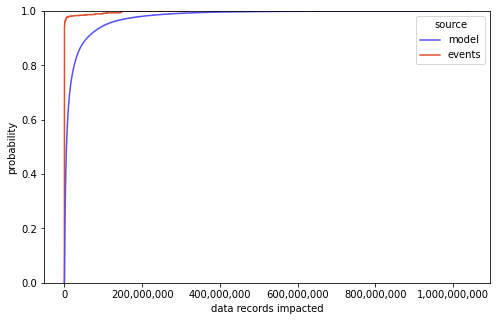

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.ecdfplot(
    data=plot_data, x="data_records_impacted", hue="source", stat="proportion", ax=ax
)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel("data records impacted")
ax.set_ylabel("probability")

### Rescale data records impacted in the model to fit the distribution of that in events
- If we assume the `number_of_data_records` given in the model is correct, the difference in distribution of the `data_records_impacted` is likely driven by the scaling factor `data_scale` applied in the model.
- The analysis below attempts to rescale the `data_records_impacted` in the model data to match that in the events data.
- By rescaling the `data_records_impacted` in the model data, we can calculate a new data scale factor, `data_scale_corrected`.
- We can attempt to try and identify the underlying distribution for the new field `data_scale_corrected`

In [16]:
events_data["data_records_impacted_quartile"] = pd.cut(
    events_data["data_records_impacted"], bins=100, labels=False
)
events_quartiles = (
    events_data.groupby("data_records_impacted_quartile", as_index=False)
    .agg(median_event_quartile_value=("data_records_impacted", "median"))
    .drop(columns="data_records_impacted_quartile")
    .reset_index()
    .rename(columns={"index": "data_records_impacted_quartile"})
)
model_data["data_records_impacted_quartile"] = pd.cut(
    model_data["data_records_impacted"], bins=events_quartiles.shape[0], labels=False
)
joined_model_event_quartiles = model_data.merge(
    events_quartiles,
    how="left",
    left_on="data_records_impacted_quartile",
    right_on="data_records_impacted_quartile",
)
#create a new column that describes the new scaling factor
joined_model_event_quartiles["data_scale_corrected"] = (
    joined_model_event_quartiles["median_event_quartile_value"]
    / joined_model_event_quartiles["number_of_data_records"]
)

In [17]:
plot_data = pd.concat(
    [
        events_data[["data_records_impacted", "source"]],
        joined_model_event_quartiles[["median_event_quartile_value", "source"]].rename(
            columns={"median_event_quartile_value": "data_records_impacted"}
        ),
    ],
    ignore_index=True,
)

### Plots after percentile normalization

Text(0.5, 0, 'data records impacted')

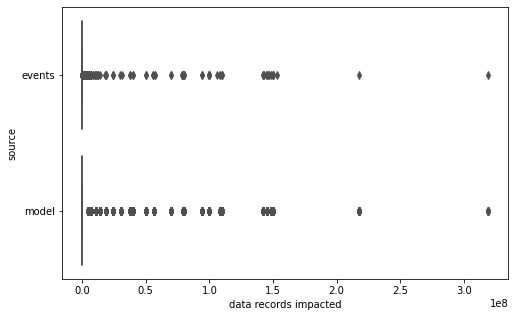

In [18]:
# plot data
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.boxplot(data=plot_data, x="data_records_impacted", y="source", orient="h", ax=ax)
ax.set_xlabel("data records impacted")

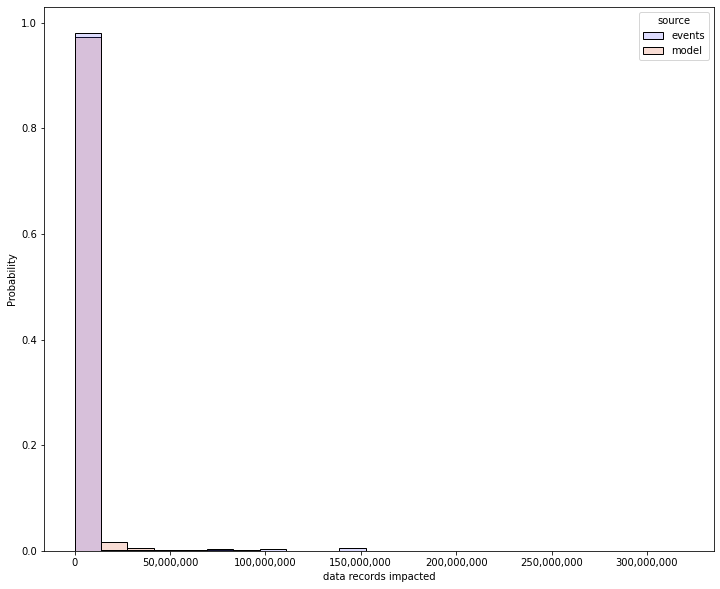

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.histplot(
    data=plot_data,
    x="data_records_impacted",
    hue="source",
    stat="probability",
    alpha=0.2,
    common_norm=False,
    ax=ax,
)
ax.set_xlabel("data records impacted")
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))

Text(0, 0.5, 'probability')

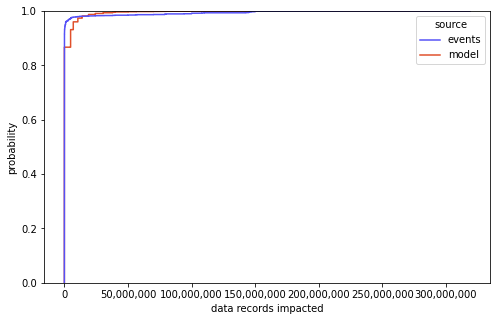

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.ecdfplot(
    data=plot_data, x="data_records_impacted", hue="source", stat="proportion", ax=ax
)
ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel("data records impacted")
ax.set_ylabel("probability")

### Plot of the data-scale parameter using values before normalization and after normalization

Text(0, 0.5, 'probability')

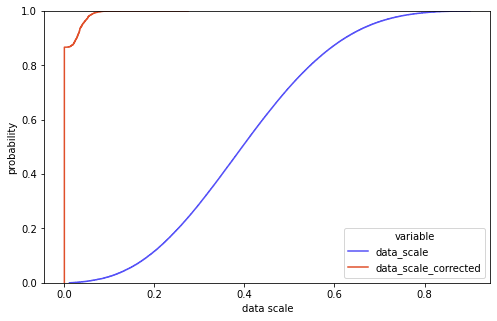

In [21]:
# plot data scale distributions
plot_data = joined_model_event_quartiles[["data_scale", "data_scale_corrected"]].melt(value_vars=['data_scale','data_scale_corrected'])
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.ecdfplot(
    data=plot_data, x="value", hue="variable", stat="proportion", ax=ax
)
ax.set_xlabel("data scale")
ax.set_ylabel("probability")

### Identify the corresponding distributions and parameter values for data_scale and data_scale_corrected 

In [22]:
df_filtered = joined_model_event_quartiles[
    (joined_model_event_quartiles["data_scale"].notnull())
    & (joined_model_event_quartiles["data_scale_corrected"].notnull())
]
results_data_scale = dist_chi_square_fit_tests(
    df=df_filtered,
    column="data_scale",
    distribution_names=[
        "weibull_min",
        "norm",
        "f",
        "beta",
        "invgauss",
        "chi2",
        "gamma",
        "expon",
        "lognorm",
        "pearson3",
        "triang",
    ],
)

In [23]:
results_data_scale

,distribution,chi_square,parameters
3,beta,314.16,"(3.4002249673591507, 4.438677419075384, -0.027051514288964594, 0.9869278726618165)"
0,weibull_min,"4,428.54","(2.8290788170889454, -0.025522136883380606, 0.47909567939894815)"
5,chi2,"18,174.04","(43.416843135486985, -0.3849324180475442, 0.01808480647172768)"
4,invgauss,"24,527.60","(0.020515693120484152, -0.7671872840998637, 56.860576002976636)"
6,gamma,"27,569.84","(57.464292521512164, -0.8473425690317415, 0.021723446294886026)"
9,pearson3,"27,821.24","(0.2662380162748146, 0.40105789948888626, 0.16468424733096065)"
8,lognorm,"30,730.58","(0.07990129816085081, -1.655190553537592, 2.0497003065120145)"
2,f,"31,502.22","(242.20343797920214, 1056.2186849896561, -1.2315661179411141, 1.6299115508181021)"
10,triang,"61,499.82","(0.36497562586836063, 0.00914782963396607, 0.8922572698760276)"
1,norm,"63,544.08","(0.4010586540051277, 0.16430751260853252)"


In [24]:
ks_test_data_scale = ks_goodness_of_fit(
    df=df_filtered,
    column="data_scale",
    distribution_names=[
        "beta",
        "weibull_min",
        "chi2"
    ],
)

In [25]:
ks_test_data_scale

,distribution,ks_statistic,p_value,parameters
0,beta,0.00,0.00,"(3.4002249673591507, 4.438677419075384, -0.027051514288964594, 0.9869278726618165)"
1,weibull_min,0.01,0.00,"(2.8290788170889454, -0.025522136883380606, 0.47909567939894815)"
2,chi2,0.02,0.00,"(43.416843135486985, -0.3849324180475442, 0.01808480647172768)"


In [26]:
results_data_scale_corrected = dist_chi_square_fit_tests(
    df=df_filtered,
    column="data_scale_corrected",
    distribution_names=[
        "weibull_min",
        "norm",
        "f",
        "beta",
        "invgauss",
        "chi2",
        "gamma",
        "expon",
        "lognorm",
        "pearson3",
        "triang",
    ],
)

In [27]:
results_data_scale_corrected

,distribution,chi_square,parameters
4,invgauss,"118,969.45","(94691.1542720843, -1.0531019438079875e-09, 5.3821730099249276e-08)"
2,f,"2,950,986.07","(0.8993996344809873, 1.034866566647469, 8.62853096657929e-10, 1.3667187929326663e-07)"
8,lognorm,"6,343,565.47","(3.449478216201662, -7.741886663235977e-09, 5.331605930678977e-07)"
6,gamma,"7,576,517.09","(0.08826542610138188, 8.628530966574914e-10, 0.059994185808993815)"
3,beta,"7,639,436.19","(0.08858964447890293, 479.8725101255146, 8.628320795905737e-10, 27.622404814616047)"
5,chi2,"7,689,328.68","(0.1777334368618717, 8.62853096657929e-10, 0.02819115933011035)"
0,weibull_min,"9,106,213.64","(0.12621939089360606, 8.62853096657929e-10, 0.01048809488924178)"
9,pearson3,"21,618,891.30","(2.5952793969515504, 0.002738113143805841, 0.003553083289859149)"
7,expon,"21,824,035.23","(8.628530966579291e-10, 0.005096520850369713)"
1,norm,"22,889,411.79","(0.0050965217132228095, 0.014282063024055252)"


In [28]:
ks_test_data_scale_corrected = ks_goodness_of_fit(
    df=df_filtered,
    column="data_scale_corrected",
    distribution_names=[
        "beta",
        "weibull_min",
        "chi2"
    ],
)

In [29]:
ks_test_data_scale_corrected

,distribution,ks_statistic,p_value,parameters
0,beta,0.47,0.00,"(0.08858964447890293, 479.8725101255146, 8.628320795905737e-10, 27.622404814616047)"
1,weibull_min,0.59,0.00,"(0.12621939089360606, 8.62853096657929e-10, 0.01048809488924178)"
2,chi2,0.47,0.00,"(0.1777334368618717, 8.62853096657929e-10, 0.02819115933011035)"


### Identifying the differences in compromised data types between the events and model data

In [30]:
#group data records impacted to match the definition in df_model
data_type_map = {"'Business_Interruption'":'OTHER', "'Corporate_Digital_Assets'":'OTHER', "'Corporate_Financial_Assets'":'OTHER', "'Unknown'":'OTHER', 'None': 'OTHER', "'PFI'":'PCI', "'PHI'":'PHI',"'PII'":'PII'}
df_modified_events['mapped_compromised_data_types'] = df_modified_events['compromised_data_types'].map(data_type_map)

In [31]:
#calculate the number of data records impacted by type - assumes data records in model will be impacted based on data type split
data_types = ['PCI','PHI','PII','OTHER']
columns = ['data_split_pci','data_split_phi','data_split_pii','data_split_other']
for data_type,column in zip(data_types,columns):
    df_model[f'{data_type}'] = df_model['data_records_impacted'] * df_model[column]

In [32]:
#data to be plotted
data_types = ['PCI','PHI', 'PII', 'OTHER']
compromised_events = df_modified_events[['data_records_impacted','mapped_compromised_data_types','source']].rename(columns={'mapped_compromised_data_types':'compromised_data_types'})
compromised_model = df_model[['PCI','PHI', 'PII', 'OTHER','source']].melt(id_vars='source',value_vars=data_types,var_name='compromised_data_types',value_name='data_records_impacted')
plot_data = pd.concat([compromised_events, compromised_model], ignore_index=True)

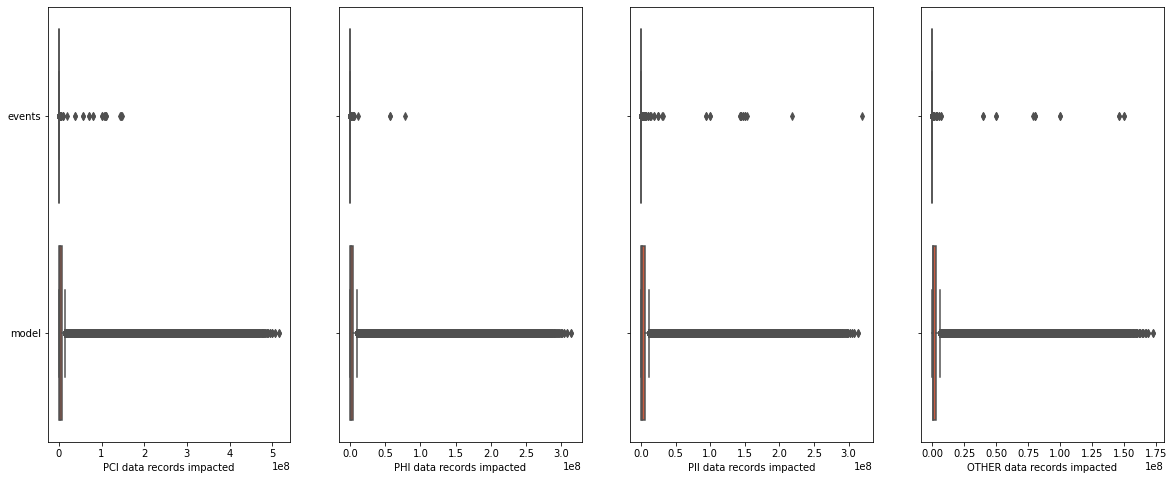

In [33]:
#comparison of distribution of compromised data types between events and model
data_types = ['PCI','PHI','PII','OTHER']
fig, ax = plt.subplots(1, 4, figsize=(20, 8), sharey = True)
for i, data_type in enumerate(data_types):
    subset_plot_data = plot_data[plot_data['compromised_data_types']==data_type]
    plot = sns.boxplot(data=subset_plot_data, x="data_records_impacted", y="source", orient="h", ax=ax[i])
    plot.set(ylabel=None)
    ax[i].set_xlabel(f"{data_type} data records impacted")

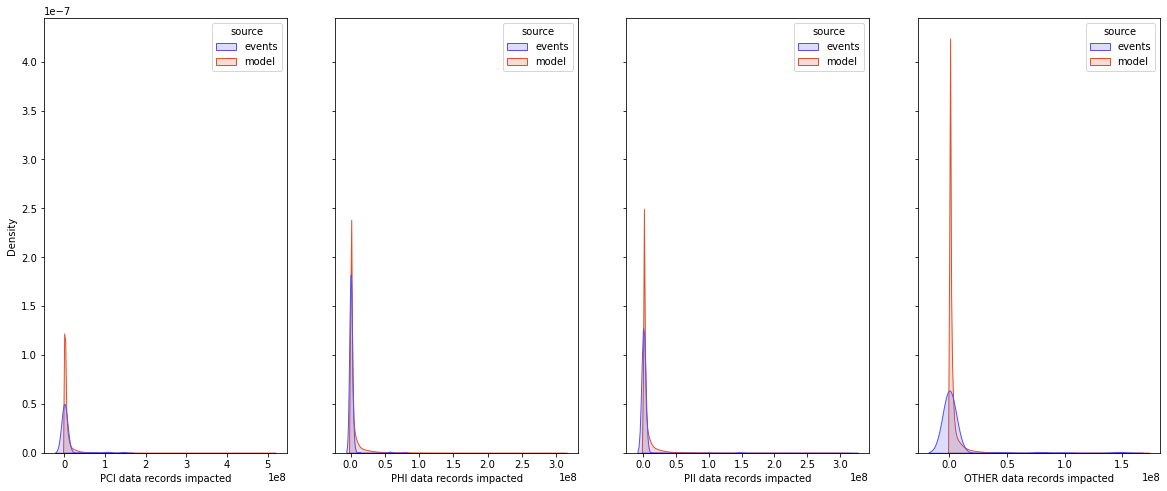

In [34]:
#comparison of distribution of compromised data types between events and model
data_types = ['PCI','PHI','PII','OTHER']
fig, ax = plt.subplots(1, 4, figsize=(20, 8), sharey = True)
for i, data_type in enumerate(data_types):
    subset_plot_data = plot_data[plot_data['compromised_data_types']==data_type]
    plot = sns.kdeplot(data=subset_plot_data,x="data_records_impacted", hue="source",fill=True,alpha=0.2,common_norm=False,ax=ax[i])
    ax[i].set_xlabel(f"{data_type} data records impacted")